# NEURON tutorial - part 1


A typical procedure of model construction and simulation in NEURON goes like this:

1. Prepare the morphologies of neurons,
2. Add intrinsic mechanisms in neurons,
3. Set up external stimuli and networks wirings,
4. Set up data recorders,
5. Run the simulation,
6. Collect data from recorders and save them.

We begin with the step 1, which requires understanding about sections and segments.

## 1. Sections and segments

NEURON is a simulator that is designed to simulate neurons with realistic extended morphologies. How can NEURON do this? Basically in NEURON, each cell is represented as a collection of cylinders, called **sections**.

<center><img src=./images/from_book_1.png width=400></center>

Here we show a part of a reconstructed neuron with a cell body (soma), axon, and some dendrites (Top) and how they are represented by different sections (Bottom).

**<center>DEMO - [NeuroMorpho.org](http://neuromorpho.org/neuron_info.jsp?neuron_name=3m_control_DG_9_3)</center>**

Then, we simulate the electrical activity of a whole neuron by computing the electrical dynamics of coupled sections.

<center><img src=./images/from_slides_1.png width=400></center>

The problem is that neurons oftentimes have sections with quite different sizes. They can be long and thick or short and tiny. To deal with this problem, each section is divided into **segments**, and so we can divide big sections with many segments while we can keep small ones with less or no segmenting.

This scheme gives us four morphological parameters for each section,

1. `L`: length of a section,
2. `diam`: diameter,
3. `nseg`: a number of segments,
4. `x`: a *relative* coordinate along a section. `x=0` and `x=1` represent one and the other end, and `x=0.5` represents a middle point.

<img src=./images/cylinder.png width=500>


Then, every dynamical variable such as membrane potential is computed segment by segment. For example, if our section has `nseg=3`, membrane potential at three different points, v(x=0.0), v(x=0.5), and v(x=1.0), can be different from each other. However, if `nseg=1`, v(x) will be exactly the same no matter which point we measure --- the section is isopotential. Having this in mind, let's open NEURON and create some sections.

In [2]:
from neuron import h, gui

In [3]:
axon = h.Section(name="axon")

Now let's inspect what's in `axon`.

In [4]:
h.psection()
# axon.psection()

axon { nseg=1  L=100  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
}


1.0

We can see that `axon` is created with default values for the shape parameters and also others such as `cm` and `Ra`, which represent *capacitance* and *axial resistance* of this section, respectively. `L=100` means that the length is 100 μm, and `diam=500` means that the diameter is 500 μm.

We can change into a thin and long axon as

In [5]:
axon.L = 500 # 500 um long
axon.diam = 1 # 1 um diameter 

h.psection()

axon { nseg=1  L=500  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=1}
	insert capacitance { cm=1}
}


1.0

## Default units used in NEURON

|Quantity | Unit|
|:--------|:-----|
|Time | ms |
|Voltage | mV |
|Current density (distributed) | mA/cm2 |
|Current (point process) | nA |
|Concentration | mM |
|Specific capacitance | uF/cm2 |
|Length | um |
|Conductance density (distributed) | S/cm2 |
|Conductance (point process) | uS |
|Axial resistance | ohm cm |
|Resistance | Mohm|


## 2. Membrane and intracellular mechanisms

Once the morphologies of neurons are prepared, cells are ready for embedding dynamical mechanisms. During the course, you will learn about ion channels and and other membrane/intracellular mechanisms, but here the first mechanism will be `pas`, which is a simple membrane electric resistance describing leaking of the electric current through the cellular membrane, according to the Ohm's law,

$$
i = g (v - E),
$$
where $i$ is a current density per area leaking out from the intracellular to extracellular domain. $v$ is the membrane potential, $g$ is the conductance per area, and $E$ is a parameter called the reversal potential, typically around -70 mV.

This mechanism can be inserted into the section `axon` as:

In [6]:
axon.insert("pas")

axon

Now we inspect this again,

In [7]:
h.psection()

axon { nseg=1  L=500  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=1}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}


1.0

## 3. External stimuli and network wirings

Neurons should be driven by external stimuli and/or other cells via network connections. In NEURON, these are implemented by embedding objects called *point processes* in each cell. Here, we add a simple external stimuli, which is called the [*current clamp*](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=iclamp#IClamp), which simulates an electrode that injects a certain amount of electric current for a given time period.

We will add this curren clamp electrode at the x$\approx$0 location of our `axon` (one end). (x=0 is the very end and can cause an undesirable behavior)

**Note: when you change `nseg`, you have to move the electrode again!!!** 

In [8]:
ic = h.IClamp(axon(0))

`IClamp` has three parameters (see [documentation](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=iclamp#IClamp)), delay, dur(ation), amp(litude). We set the parameters as

In [9]:
ic.delay = 0 # 0 ms delay
ic.dur = 1e2 # 100 ms duration
ic.amp = 0.200 # 200 pA

In [10]:
h.psection()

axon { nseg=1  L=500  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=1}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}


1.0

## 4. Data recorders

We will record the membrane potential of this axon at three different locations, x$\approx$0, x=0.5, and x=1. For this, we will need to prepare the data placeholders called [vectors](https://www.neuron.yale.edu/neuron/static/py_doc/programming/math/vector.html) and specify how which variable at where is recorded.

So let's create a list of vectors first,

In [11]:
reclist = []
for i in range(3):
    reclist.append(h.Vector())
reclist

[Vector[163], Vector[164], Vector[165]]

Now we will record the membrane potential `v` at x=0.001, 0.5, and 1, every 0.1 ms (see [documentation](https://www.neuron.yale.edu/neuron/static/py_doc/programming/math/vector.html?highlight=vector#Vector.record) for more detail)

In [12]:
dt = 0.1
reclist[0].record(axon(1e-3)._ref_v, dt)
reclist[1].record(axon(0.5)._ref_v, dt)
reclist[2].record(axon(1)._ref_v, dt)

Vector[165]

## 5. Running simulation

In most cases, we can simply call `h.init()` and `h.run()` after setting `h.tstop`, which sets how long the simulation will run.

In [17]:
from neuron import h, gui

# h.tstop = 100 # 100 ms duraion
h.init() #initialize the simulation
# h.run() #run!
h.continuerun(100)

0.0

## 6. Collecting, inspecting, and saving the data

Now we check if the data are collected well...

In [18]:
print(reclist[0].size())

1001


Since dt=0.1, the recorded data is a vector, [v(t=0), v(t=0.1), v(t=0.2),...,v(t=100)], whose length should be 1001. We can plot the data now.

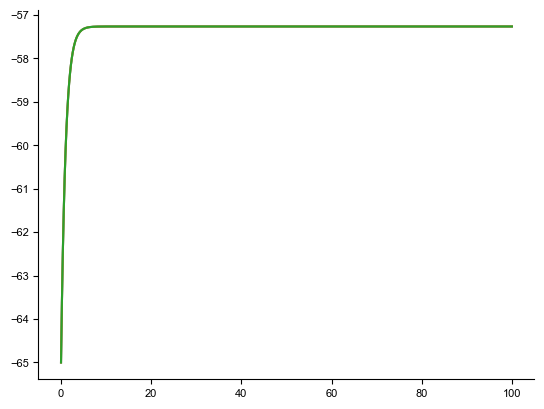

In [19]:
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(1001)*dt
fig, ax = plt.subplots()

ax.plot(t, reclist[0],
        t, reclist[1],
        t, reclist[2])

Here we see three curves are exactly the same since currently nseg = 1 and the section is isopotential. This is obviously not good! Let's change this, and run the simulation again,..

In [22]:
axon.nseg = 100 # split the section by dx = 500/100 = 5 um.

h.psection(axon)

axon { nseg=100  L=500  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert pas { g_pas=0.001 e_pas=-70}
	insert capacitance { cm=1}
	insert morphology { diam=1}
}


1.0

Here we check the electrode location:

In [23]:
ic.get_loc()

0.0

**Now it is in the middle!** Let's move this to one end that we wanted it to be originally:

NOT ANYMORE

In [24]:
ic.loc(0)

0.0

Now the electrode has relocated.

In [25]:
# Here we define a function for setting recordings and running
def run_and_record():
    reclist = []
    for i in range(3):
        reclist.append(h.Vector())

    dt = 0.1
    reclist[0].record(axon(1e-3)._ref_v, dt)
    reclist[1].record(axon(0.5)._ref_v, dt)
    reclist[2].record(axon(1)._ref_v, dt)

    h.init()
    h.run()
    
    return(reclist)

reclist = run_and_record()

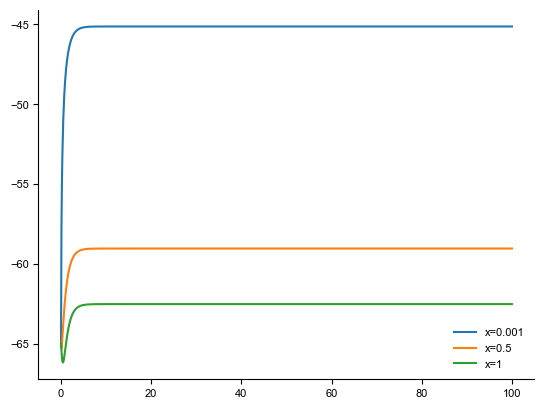

In [26]:
def plot_recordings(reclist):
    t = np.arange(1001)*dt
    fig, ax = plt.subplots()
    ax.plot(t, reclist[0], label="x=0.001")
    ax.plot(t, reclist[1], label="x=0.5")
    ax.plot(t, reclist[2], label="x=1")
    ax.legend()
    return fig

_ = plot_recordings(reclist)

Now, let's change the intrinsic property of this axon by inserting a set of active ion channels called "Hodgkin-Huxley mechanisms", `hh`, and see what happens...

In [27]:
axon.insert('hh')

reclist = run_and_record()

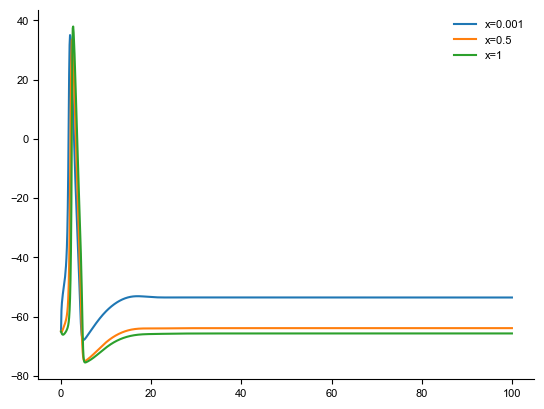

In [28]:
_ = plot_recordings(reclist)

Now, we can also change how the system's behavior changes with parameter change. We added two mechanisms `pas` and `hh`, and let's "turn off" `pas` by setting its conductance to zero.

In [30]:
axon.g_pas = 0
h.psection()

axon { nseg=100  L=500  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert pas { g_pas=0 e_pas=-70}
	insert capacitance { cm=1}
	insert morphology { diam=1}
	insert hh { gnabar_hh=0.12 gkbar_hh=0.036 gl_hh=0.0003 el_hh=-54.3}
	insert na_ion { ena=50}
	insert k_ion { ek=-77}
}


1.0

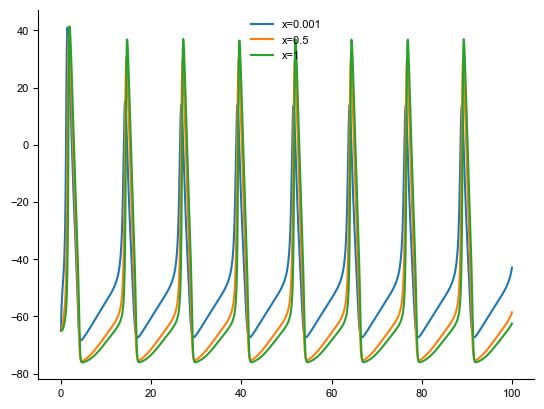

In [31]:
reclist = run_and_record()
_ = plot_recordings(reclist)

We save the data by using `pandas` package. 

In [32]:
import pandas as pd
df = pd.DataFrame({'t':np.arange(1001)*dt,
                   'x=0.001': reclist[0],
                   'x=0.5': reclist[1],
                   'x=1': reclist[2]})
df

,t,x=0.001,x=0.5,x=1
0,0.0,-65.000000,-65.000000,-65.000000
1,0.1,-57.125396,-64.800353,-64.993143
2,0.2,-53.766373,-64.133301,-64.941181
3,0.3,-51.223631,-63.217883,-64.775640
4,0.4,-48.959491,-62.206378,-64.466747
...,...,...,...,...
996,99.6,-46.064005,-60.214744,-63.620435
997,99.7,-45.432194,-59.858094,-63.363791
998,99.8,-44.719573,-59.469776,-63.093420
999,99.9,-43.904336,-59.041467,-62.805947


`pandas` supports various file formats. Here we use CSV.

In [33]:
df.to_csv('axon_data.csv', index=False)